# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

rng = np.random.default_rng(seed=41)

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('./Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('./AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print(f'The shape of the azdias data is {azdias.shape}.\n')
print('{0} The first few rows of the azdias data {0}\n'.format('-' * 5))
azdias.head()

The shape of the azdias data is (891221, 85).

----- The first few rows of the azdias data -----



,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
print('{0} Some General statistics for the azdias data{0}'.format('-' * 5))
azdias.describe()

----- Some General statistics for the azdias data-----


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [5]:
print(f'The shape of the feat_info data is {feat_info.shape}.\n')
print('{0} The first 10 rows of the feat_info data {0}\n'.format('-' * 5))
feat_info.head(10)

The shape of the feat_info data is (85, 4).

----- The first 10 rows of the feat_info data -----



,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

--First assess the naturally missing values as opposed to coded missing--

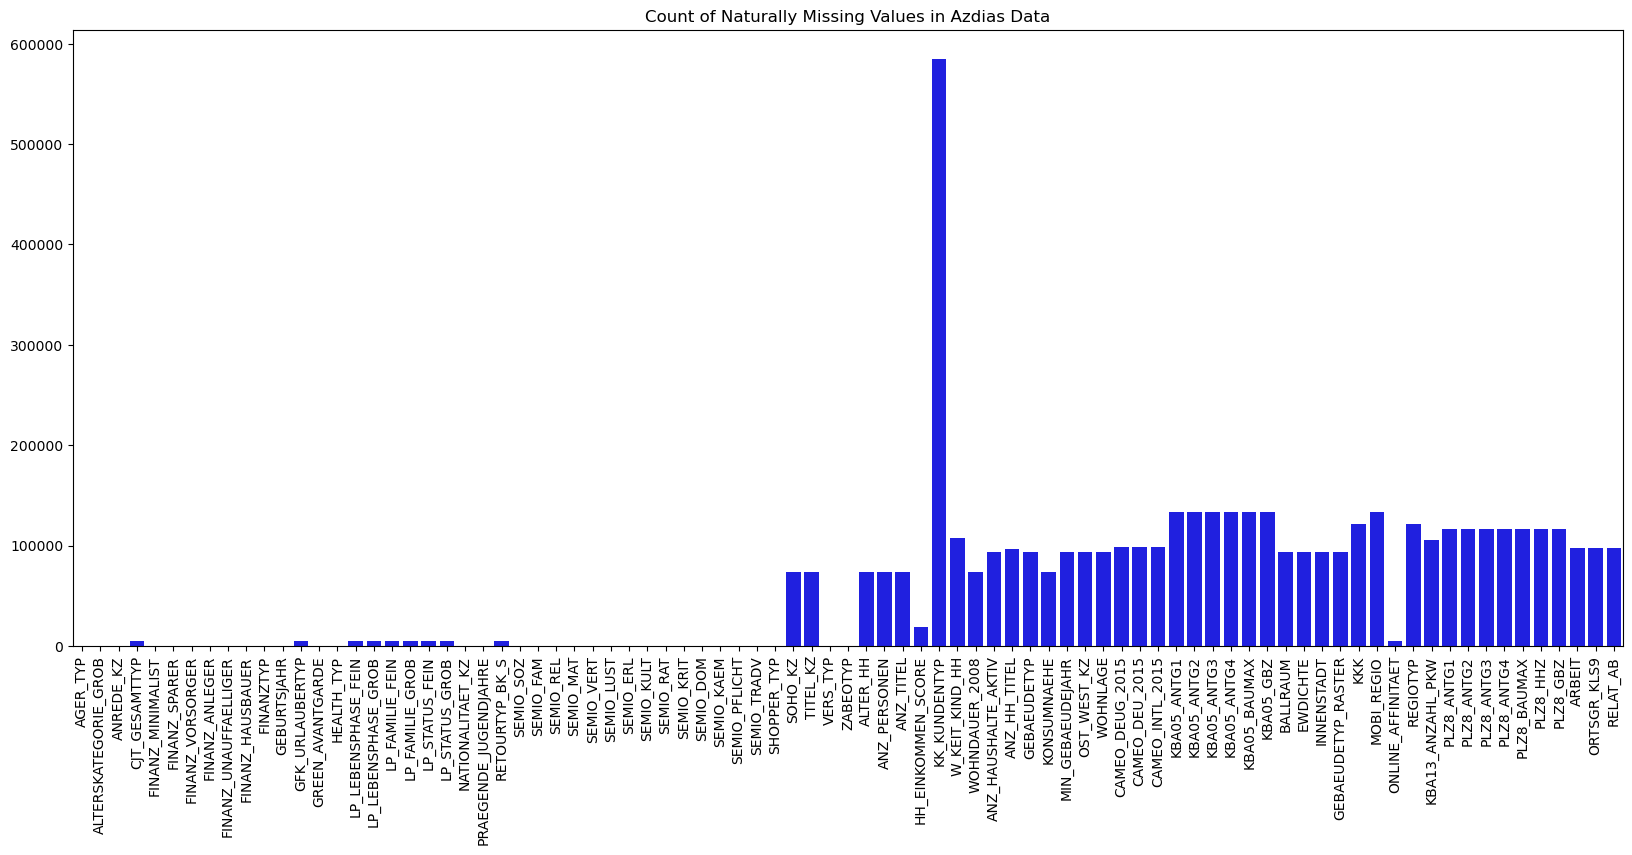

In [6]:
# visualize how many rows per column have naturally null values.
naturally_missing = azdias.isnull().sum()

plt.figure(figsize=(20,8))
sns.barplot(x=naturally_missing.index,
            y=naturally_missing.values,
            color='blue'
           );
plt.xticks(rotation=90);
plt.title('Count of Naturally Missing Values in Azdias Data');

--There appear to be many naturally missing values, it needs to be assured that these values are represented as np.nan--
* These naturally missing values are mostly related to ****
* The field with the most missing is KK_KUNDENTYP which denotes the consumer pattern over the past 12 months (unknown, regular customer, active customer, etc).  It is missing well over half of the values.

In [7]:
# replace the naturally missing values with np.nan to ensure they are coded correctly.
azdias.fillna(np.nan, inplace=True)

---Replace the coded vales with np.nan---

In [8]:
# Identify missing or unknown data values and convert them to NaNs.
# cleaning function to use while building the dictionary that defines which values are missing
def clean_value(value):
    try:
        value_out = eval(value)
        return value_out
    except:
        if value == '[-1,X]':
            value_out = ['-1', 'X']
        if value == '[XX]':
            value_out = ['XX']
        if value == '[-1,XX]':
            value_out = ['-1', 'XX']
        return value_out


# get a dictionary of missing or unknown values
missing_list = feat_info[['attribute','missing_or_unknown']].to_dict('tight').get('data')
missing_dict = {key: clean_value(value) for key, value in missing_list}

# replace the missing values in the data frame
azdias.replace(missing_dict, np.nan, inplace=True)

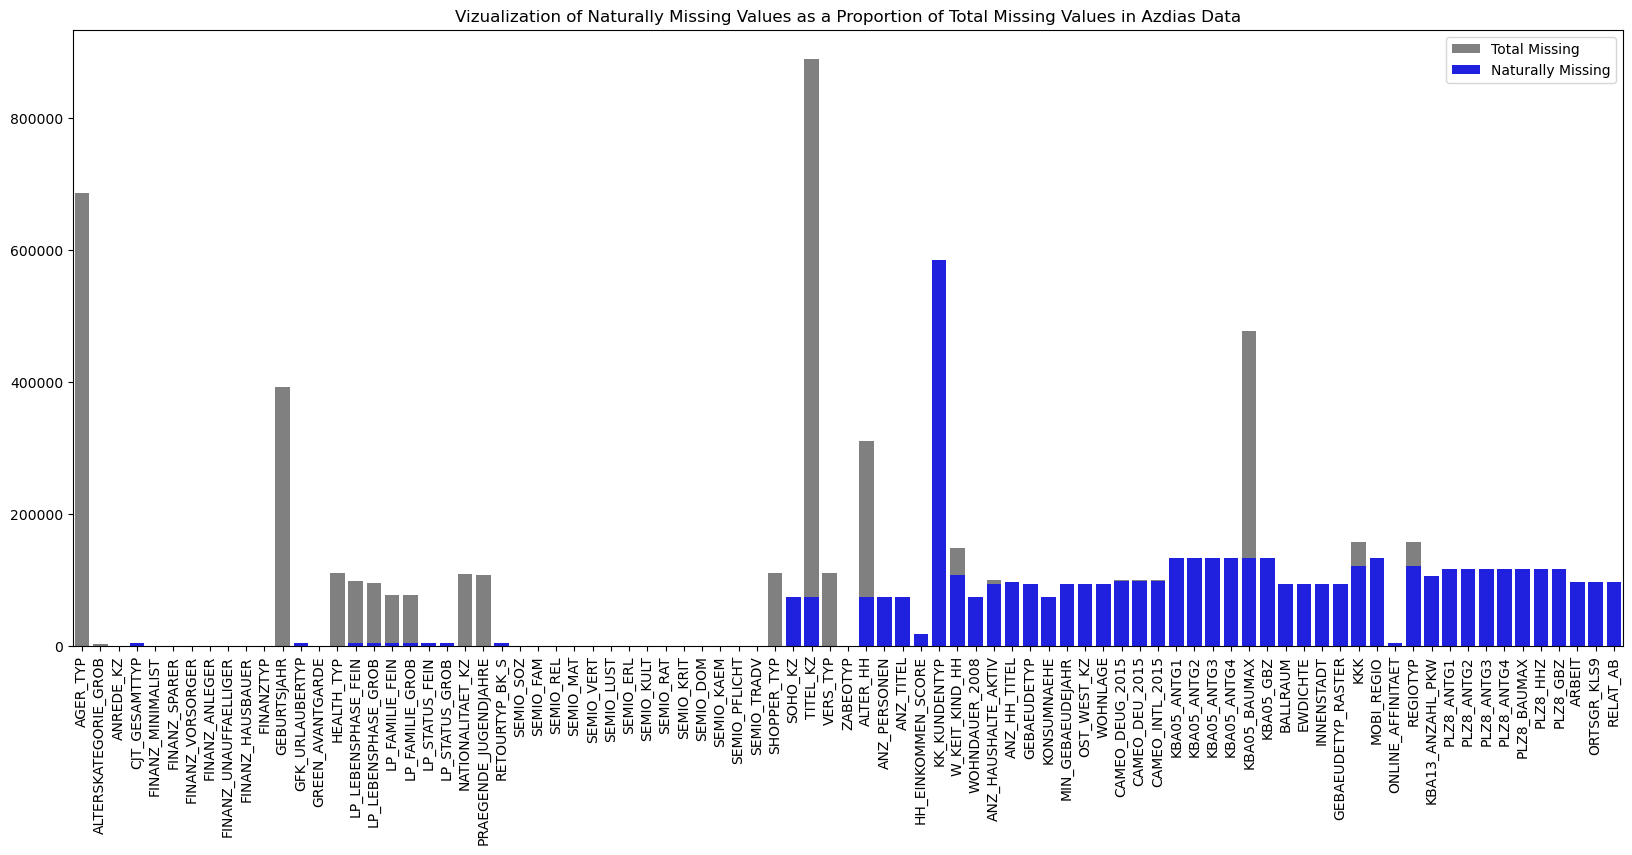

In [9]:
# overlay the previous naturally missing values with the coded values to visualize the total missing to get a sense of total missing vs naturally missing.
total_missing = azdias.isnull().sum()

fig, ax = plt.subplots(figsize=(20, 8))

#plot the total missing
sns.barplot(x=total_missing.index,
            y=total_missing.values,
            color='grey',
            ax=ax,
            label='Total Missing'
           );


sns.barplot(x=naturally_missing.index,
            y=naturally_missing.values,
            color='blue',
            ax=ax,
            label='Naturally Missing'
           );
plt.xticks(rotation=90);
plt.title('Vizualization of Naturally Missing Values as a Proportion of Total Missing Values in Azdias Data');
plt.legend();


--In the above chart the top of the grey bar represents the total missing and the height of the blue bar is the naturally missing.  Overlaying the two bars helps visualize the proportion of naturally missing as a subset of the total missing.  The number of missing values that were coded as missing using special codes for each feature would be the difference between the top of the grey bar and the top of the blue bar.--

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

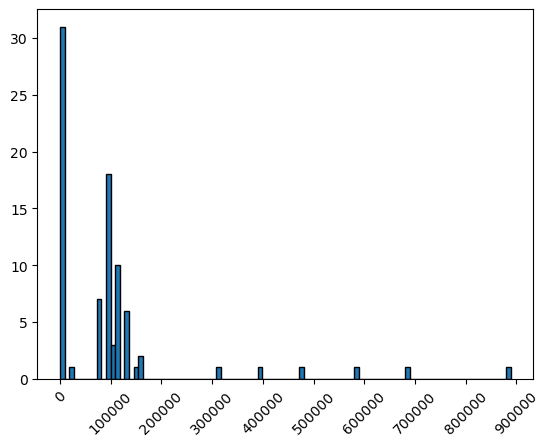

In [10]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
fig, ax = plt.subplots()
ax.hist(total_missing,
        bins='stone',
        edgecolor="black"
       );
ax.set_xticks(list(range(0,1000000,100000)));
plt.xticks(rotation=45);

In [11]:
# Investigate patterns in the amount of missing data in each column.



In [12]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
azdias.drop(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'],
            axis=1,
            inplace=True
           )

#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

From the histogram it can be seen that there are 6 outlier columns which are missing >200,000 values.  These 6 columns will be removed. They are identifiable on the barplot above that as:
* AGER_TYP
* GEBURTSJAHR
* TITEL_KZ
* ALTER_HH
* KK_KUNDENTYP
* KBA05_BAUMAX

Form the initial bar plot visualization it can be seen that there are roughly 100K observations naturally missing from nearly the entire second half of the features (as sorted in their given order) starting around SOHO_KZ

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

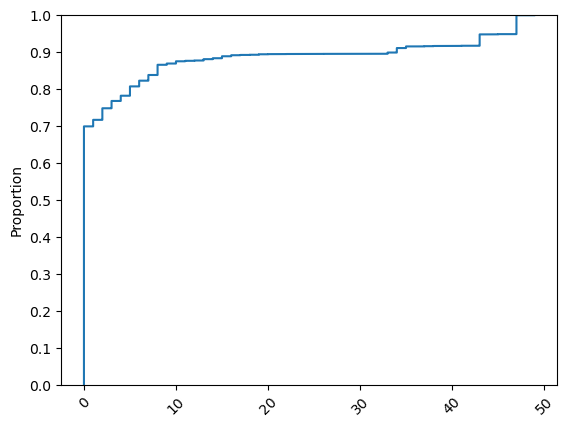

In [13]:
# How much data is missing in each row of the dataset?
missing_row = azdias.isnull().sum(axis=1)  # creates a Series that counts how many columns are null for each row

# plot a cumulative distribution function to visualize the data
fig, ax = plt.subplots()
sns.ecdfplot(missing_row, ax=ax);
plt.xticks(rotation=45);
ax.set_yticks(list(np.arange(0.0,1.1,0.1)));

-- Using a non-parametric cumuluative distribution graph, it can be seen that roughly 70% of the rows are missing no values, and 90% of the rows are missing 10 values or less. So it would seem that splitting the data between rows that have no missing values (70/30) or 10 or less (90/10) could be good options.
In order ot decide the cutoff threshold for dividing the data, it is necesarry to explore the data to understand what types of fields are missing from the dataset, and of those missing columns, what are the characteristics of that data for the rows for which those columns are not missing data
--

In [14]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
threshold = 0
threshold_lower = missing_row <= threshold
threshold_higher = missing_row > threshold

# two subsets, azdias_1 for rows below threshold for missing values,  and azdias_2 for rows above threshold
azdias_1 = azdias.loc[threshold_lower].copy()
azdias_2 = azdias.loc[threshold_higher].copy()

In [15]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# columns with missing data
columns_with_missing_data = azdias.columns[azdias.isnull().any()]

# select 5 columns at random which have missing values above the threshold to compare the distributions between the two subsets
random_missing_columns = rng.integers(0, len(columns_with_missing_data), size=5) # calculate a random array 
random_columns = columns_with_missing_data[random_missing_columns] # get the columns based on the random values


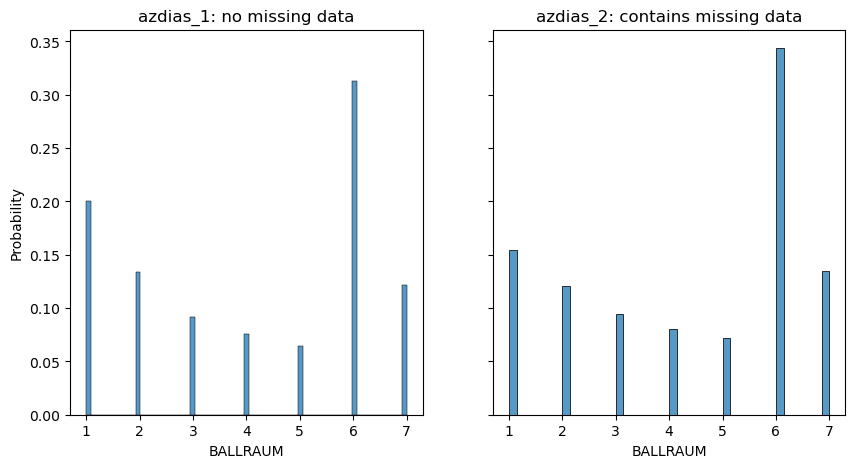

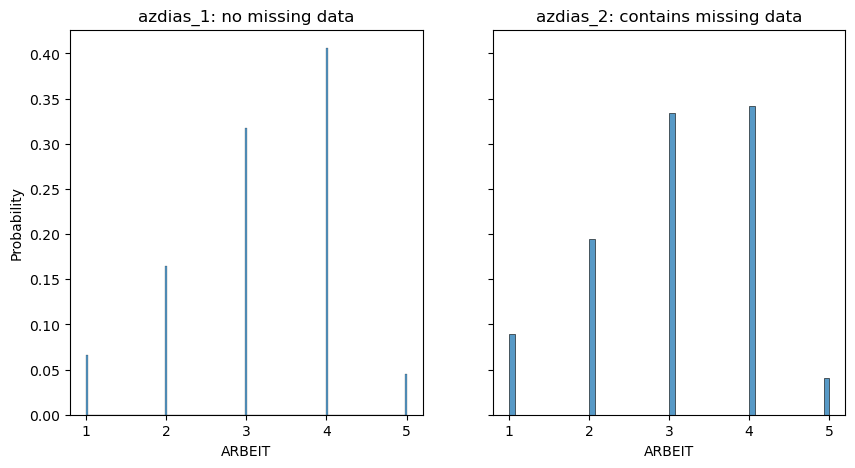

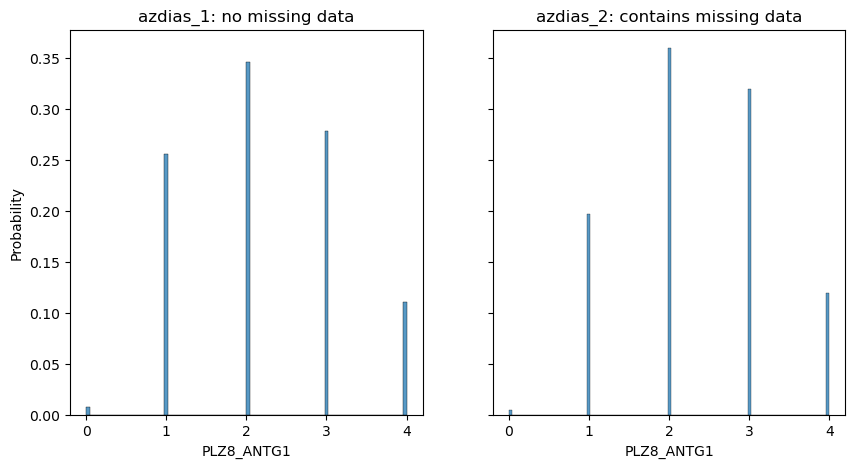

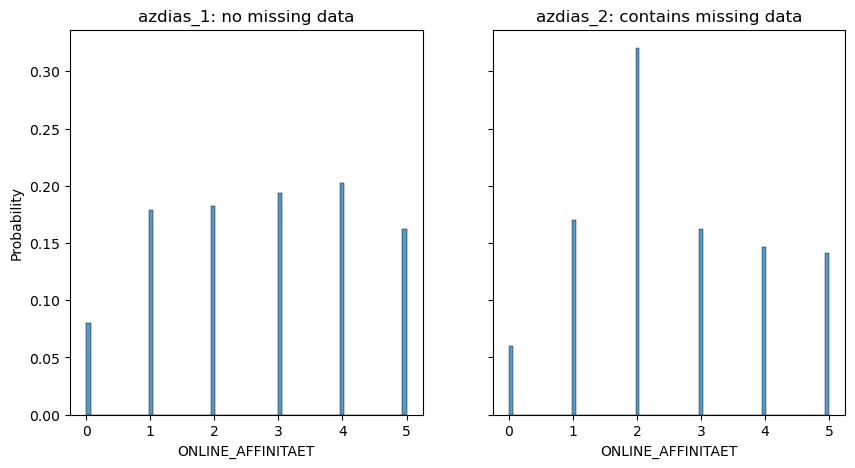

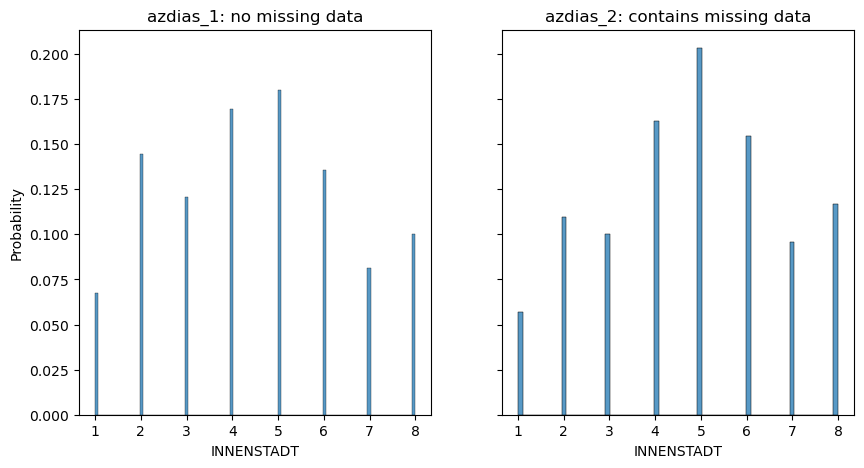

In [16]:
# plot the 5 columns distributions to compare the distribution of values between the dataset with no missing values vs. the dataset with missing values
for rand_column in random_columns:
    fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True, sharex=True);
    sns.histplot(data=azdias_1, x=rand_column, ax=axs[0], stat='probability');
    sns.histplot(data=azdias_2, x=rand_column, ax=axs[1], stat='probability');
    axs[0].set_title('azdias_1: no missing data')
    axs[1].set_title('azdias_2: contains missing data')

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?) 

After reviewing the distribution plots of 5 random columns that contain missing values, it can be seen that there is not a substantial difference in the distribution of values when comparing the subset of azdias data that has no missing values vs the subset with missing values.  


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [17]:
# How many features are there of each data type?
feat_info.groupby('type').size()


type
categorical    21
interval        1
mixed           7
numeric         7
ordinal        49
dtype: int64

-- From the above pandas Series we can see the count of columns by feature type.  The two feature types that may be necessary to handle special are 'categorical' with 21 features and 'mixed' with 7 features. Some of these features may have been removed in the removal of outlier columns of missing data.--

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [18]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# get a list of categorical features and print their values to determine the encoding strategy
# also retain a list of the multi-level categories so that those can be re-encoded in a later step
categorical_features = feat_info['attribute'].loc[feat_info['type'] == 'categorical']
categorical_features = categorical_features.to_numpy()
multi_level_categories = []

for column in azdias_1:
    if column in categorical_features:
        values = azdias_1[column].unique()
        print(f'Column {column} values are: {values}')

        if len(values) > 2:
            multi_level_categories.append(column)

Column ANREDE_KZ values are: [2 1]
Column CJT_GESAMTTYP values are: [5. 3. 2. 4. 1. 6.]
Column FINANZTYP values are: [1 5 2 4 6 3]
Column GFK_URLAUBERTYP values are: [10.  5.  1. 12.  9.  3.  8. 11.  4.  7.  6.  2.]
Column GREEN_AVANTGARDE values are: [0 1]
Column LP_FAMILIE_FEIN values are: [ 5.  1. 10.  2.  7. 11.  8.  4.  6.  9.  3.]
Column LP_FAMILIE_GROB values are: [3. 1. 5. 2. 4.]
Column LP_STATUS_FEIN values are: [ 2.  3.  4.  1. 10.  9.  5.  6.  7.  8.]
Column LP_STATUS_GROB values are: [1. 2. 5. 4. 3.]
Column NATIONALITAET_KZ values are: [1. 2. 3.]
Column SHOPPER_TYP values are: [3. 2. 0. 1.]
Column SOHO_KZ values are: [1. 0.]
Column VERS_TYP values are: [2. 1.]
Column ZABEOTYP values are: [5 4 1 6 3 2]
Column GEBAEUDETYP values are: [8. 1. 3. 5.]
Column OST_WEST_KZ values are: ['W' 'O']
Column CAMEO_DEUG_2015 values are: ['8' '4' '6' '2' '1' '9' '5' '7' '3']
Column CAMEO_DEU_2015 values are: ['8A' '4C' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5D' '9E' '9B' '1B' '8B'
 '7A' '3D' '4

In [19]:
# Re-encode categorical variable(s) to be kept in the analysis.

# re-encode the non-numeric binary feature OST_WEST_KZ
azdias_1['OST_WEST_KZ'] = azdias_1['OST_WEST_KZ'].map({'W': 0, 'O': 1})
azdias_2['OST_WEST_KZ'] = azdias_2['OST_WEST_KZ'].map({'W': 0, 'O': 1})

In [20]:
# Re-encode multi-level categories minus the multi-level categor GEBAEUDETYP which will be dropped
multi_level_categories.remove('GEBAEUDETYP')
azdias_1.drop(columns='GEBAEUDETYP', inplace=True)
azdias_2.drop(columns='GEBAEUDETYP', inplace=True)

In [21]:
# The multi-level features were previously stored in the multi_level_categories list

azdias_1_categories_encoded = pd.get_dummies(azdias_1, columns=multi_level_categories)
azdias_2_categories_encoded = pd.get_dummies(azdias_2, columns=multi_level_categories)

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

There are 21 columns labeled categorical in the azdias data. 3 of those columns had been previously dropped due to being outliers with respect to missing data.

For the remaining 18 columns:
* the 4 columns that were binary and numeric were left as-is
* the 1 column that was binary non-numeric was re-encoded to 0 and 1 values
* the 13 columns that were multi-level categorical values were one-hot encoded using the pandas get_dummies function with the exception of the feature 'GEBAEUDETYP'.  The values in GEBAEUDETYP do no match between the azdias_1 dataset and the customers dataset.  One-hot encoding these with the pandas get_dummies function would create a different number of columns for the azdias data vs the customers data.  Thefefore to keep things simple the 'GEBAEUDETYP' feature has been removed.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [22]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

#print the values and data type to get an understanding of the data 
PRAEGENDE_JUGENDJAHRE_values = azdias_1_categories_encoded['PRAEGENDE_JUGENDJAHRE'].unique()
print(np.sort(PRAEGENDE_JUGENDJAHRE_values))
print(PRAEGENDE_JUGENDJAHRE_values.dtype)


[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]
float64


In [23]:
# create a mapping dictionary to apply in the creation of 2 new columns
# decades mapped with their respective decade, and mainstream set to 0, Avantgarde to 1
PJ_mapping_dict_decade = {1: 40,
                   2: 40,
                   3: 50,
                   4: 50,
                   5: 60,
                   6: 60,
                   7: 60,
                   8: 70,
                   9: 70,
                   10: 80,
                   11: 80,
                   12: 80,
                   13: 80,
                   14: 90,
                   15: 90}

PJ_mapping_dict_nation = {1: 0,
                   2: 1,
                   3: 0,
                   4: 1,
                   5: 0,
                   6: 1,
                   7: 1,
                   8: 0,
                   9: 1,
                   10: 0,
                   11: 1,
                   12: 0,
                   13: 1,
                   14: 0,
                   15: 1}

In [24]:
# use the replace function to create new columns for PRAEGENDE_JUGENDJAHRE
azdias_1_categories_encoded['PRAEGENDE_JUGENDJAHRE_decade'] = azdias_1_categories_encoded['PRAEGENDE_JUGENDJAHRE'].replace(
    PJ_mapping_dict_decade)

azdias_2_categories_encoded['PRAEGENDE_JUGENDJAHRE_decade'] = azdias_2_categories_encoded['PRAEGENDE_JUGENDJAHRE'].replace(
    PJ_mapping_dict_decade)

azdias_1_categories_encoded['PRAEGENDE_JUGENDJAHRE_nation'] = azdias_1_categories_encoded['PRAEGENDE_JUGENDJAHRE'].replace(
    PJ_mapping_dict_nation)

azdias_2_categories_encoded['PRAEGENDE_JUGENDJAHRE_nation'] = azdias_2_categories_encoded['PRAEGENDE_JUGENDJAHRE'].replace(
    PJ_mapping_dict_nation)

In [25]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

#print the values and data type to get an understanding of the data 
CAMEO_INTL_2015_values = azdias_1_categories_encoded['CAMEO_INTL_2015'].unique()
print(np.sort(CAMEO_INTL_2015_values))
print(CAMEO_INTL_2015_values.dtype)


['12' '13' '14' '15' '22' '23' '24' '25' '31' '32' '33' '34' '35' '41'
 '43' '44' '45' '51' '52' '54' '55']
object


In [26]:
# Parse the 'ones' and 'tens' place digit
azdias_1_categories_encoded['CAMEO_INTL_2015_wealth'] = azdias_1_categories_encoded['CAMEO_INTL_2015'].str[0].astype('float64')
azdias_1_categories_encoded['CAMEO_INTL_2015_life_stage'] = azdias_1_categories_encoded['CAMEO_INTL_2015'].str[1].astype('float64')

azdias_2_categories_encoded['CAMEO_INTL_2015_wealth'] = azdias_2_categories_encoded['CAMEO_INTL_2015'].str[0].astype('float64')
azdias_2_categories_encoded['CAMEO_INTL_2015_life_stage'] = azdias_2_categories_encoded['CAMEO_INTL_2015'].str[1].astype('float64')

In [27]:
# Take a look at the other mixed features

mixed_feature = feat_info['attribute'].loc[feat_info['type'] == 'mixed']
mixed_feature = mixed_feature.to_numpy()


for column in azdias_1:
    if column in mixed_feature:
        values = azdias_1[column].unique()
        print(f'Column {column} values are: {values}')

Column LP_LEBENSPHASE_FEIN values are: [21.  3. 32.  8.  2.  5. 10.  4.  6. 20.  1. 25. 18. 31. 38. 30.  7. 22.
 14. 35. 29. 24. 37. 12. 39. 36. 13.  9. 34. 26. 33. 15. 11. 40. 16. 19.
 23. 27. 28. 17.]
Column LP_LEBENSPHASE_GROB values are: [ 6.  1. 10.  2.  3.  5.  7. 12.  9.  4. 11.  8.]
Column PRAEGENDE_JUGENDJAHRE values are: [14. 15.  8.  3. 10. 11.  9.  5.  4.  2.  6.  1. 12. 13.  7.]
Column WOHNLAGE values are: [4. 2. 3. 7. 5. 1. 8. 0.]
Column CAMEO_INTL_2015 values are: ['51' '24' '43' '54' '22' '14' '13' '15' '34' '55' '41' '25' '31' '52'
 '45' '35' '33' '44' '32' '23' '12']
Column PLZ8_BAUMAX values are: [1. 2. 4. 5. 3.]


In [28]:
#probably delete this
# create one new feature from the WOHNLAGE column

# new column will identify non-rural (WOHNLAGE 1-6) as 0 and rural (WOHNLAGE 7-8) as 1
#WOHNLAGE_mapping_dict = {1: 0,
#                         2: 0,
#                         3: 0,
#                       5: 0,
                         # 6: 0,
                         # 7: 1,
                         # 8: 1}

In [29]:
#probably delete this
# map the new column
#azdias_1_categories_encoded['WOHNLAGE_region'] = azdias_1_categories_encoded['WOHNLAGE'].replace(
 #   WOHNLAGE_mapping_dict)

#azdias_2_categories_encoded['WOHNLAGE_region'] = azdias_2_categories_encoded['WOHNLAGE'].replace(
#    WOHNLAGE_mapping_dict)

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

Both LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB deal with wealth and life stage. This seems duplicative of the two columns we created based on CAMEO_INTL_2015, so these have just been retained with no action.

WOHNLAGE describes the neighborhood quality or marks it as rural.  The non-rural neighborhoods have a note about the quality, but because the rural neighboorhood does not mention quality it would not be possible to get a quality value related to the rural community.  Therefore the column was retained as is.

PLZ8_BAUMAX describes the number of buildings in the PLZ8 region.  It has a mixed category based on whether the homes in the region are mostly family vs business.  This one was left as is.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [30]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
# Remove the two columns that were re-engineered

azdias_1_final = azdias_1_categories_encoded.drop(
    columns=['PRAEGENDE_JUGENDJAHRE',
             'CAMEO_INTL_2015'])    

azdias_2_final = azdias_1_categories_encoded.drop(
    columns=['PRAEGENDE_JUGENDJAHRE',
             'CAMEO_INTL_2015'])    


In [31]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

#DELETE

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [32]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    # replace the naturally missing values with np.nan to ensure they are coded correctly.
    df = df.copy()
    df.fillna(np.nan, inplace=True)

    
    def clean_value(value):
        try:
            value_out = eval(value)
            return value_out
        except:
            if value == '[-1,X]':
                value_out = ['-1', 'X']
            if value == '[XX]':
                value_out = ['XX']
            if value == '[-1,XX]':
                value_out = ['-1', 'XX']
            return value_out

    # get a dictionary of missing or unknown values
    missing_list = feat_info[['attribute','missing_or_unknown']].to_dict('tight').get('data')
    missing_dict = {key: clean_value(value) for key, value in missing_list}
    
    # replace the missing values in the data frame
    df.replace(missing_dict, np.nan, inplace=True)
    
    
    # remove selected columns and rows, ...
    df.drop(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'],
            axis=1,
            inplace=True
           )
    
    #re-encode categorical feature OST_WEST_KZ
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map({'W': 0, 'O': 1})

        # get a list of categorical features and print their values to determine the encoding strategy
    # also retain a list of the multi-level categories so that those can be re-encoded in a later step
    categorical_features = feat_info['attribute'].loc[feat_info['type'] == 'categorical']
    categorical_features = categorical_features.to_numpy()
    multi_level_categories = []
    
    for column in df:
        if column in categorical_features:
            values = df[column].unique()
            value_count = df[column].nunique(dropna=True)
           # print(f'Column {column} values are: {values}')
    
            if value_count > 2:
                multi_level_categories.append(column)

    
    # select, re-encode, and engineer column values.
    multi_level_categories.remove('GEBAEUDETYP')
    df.drop(columns='GEBAEUDETYP', inplace=True)
    
    df = pd.get_dummies(df, columns=multi_level_categories)

    PJ_mapping_dict_decade = {1: 40,
                   2: 40,
                   3: 50,
                   4: 50,
                   5: 60,
                   6: 60,
                   7: 60,
                   8: 70,
                   9: 70,
                   10: 80,
                   11: 80,
                   12: 80,
                   13: 80,
                   14: 90,
                   15: 90}

    PJ_mapping_dict_nation = {1: 0,
                   2: 1,
                   3: 0,
                   4: 1,
                   5: 0,
                   6: 1,
                   7: 1,
                   8: 0,
                   9: 1,
                   10: 0,
                   11: 1,
                   12: 0,
                   13: 1,
                   14: 0,
                   15: 1}

    df['PRAEGENDE_JUGENDJAHRE_decade'] = df['PRAEGENDE_JUGENDJAHRE'].replace(
        PJ_mapping_dict_decade)
    
    df['PRAEGENDE_JUGENDJAHRE_nation'] = df['PRAEGENDE_JUGENDJAHRE'].replace(
        PJ_mapping_dict_nation)

    df['CAMEO_INTL_2015_wealth'] = df['CAMEO_INTL_2015'].str[0].astype('float64')
    df['CAMEO_INTL_2015_life_stage'] = df['CAMEO_INTL_2015'].str[1].astype('float64')

    df = df.drop(
        columns=['PRAEGENDE_JUGENDJAHRE',
                 'CAMEO_INTL_2015'])

    return df

    
        
    # Return the cleaned dataframe.
    
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [33]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
azdias_scaled = scaler.fit_transform(azdias_1_final)


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

The azdias data set used already contained no missing values, so no imputation was needed.  The data was then standardized so that the data can be used with PCA.  

Standardization is important when applying PCA so that higher variances in one feature do not bias the algorithm.  See this [link](https://datascience.stackexchange.com/questions/86448/principal-components-analysis-need-standardization-or-normalization)

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [34]:
# Apply PCA to the data.
pca = PCA(150)
X_pca = pca.fit_transform(azdias_scaled)


In [35]:
#calculate variance attributes
num_components = pca.explained_variance_ratio_.shape[0]

x_axis = np.arange(num_components)
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

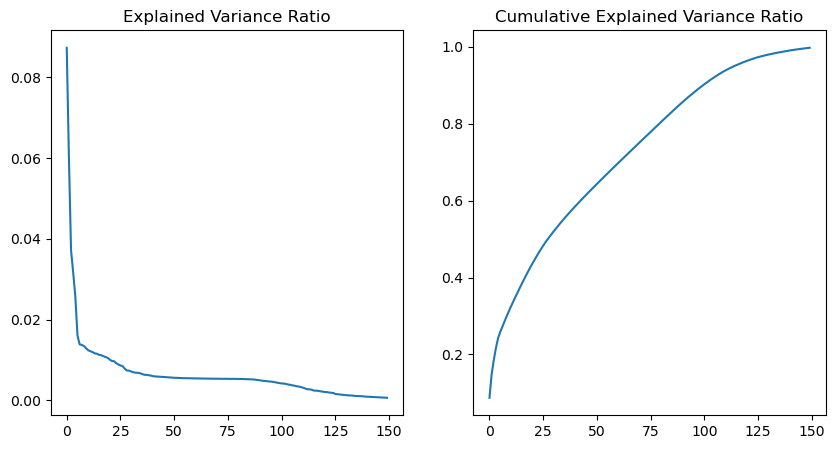

In [36]:
# Investigate the variance accounted for by each principal component.
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True)
axs[0].plot(x_axis, pca.explained_variance_ratio_);
axs[0].set_title("Explained Variance Ratio");
axs[1].plot(x_axis, cumulative_variance_ratio);
axs[1].set_title("Cumulative Explained Variance Ratio");

In [37]:
# The cumulative explained variance ratio curve looks to flatten out starting around 125 components.  Therefore 125 components will be used in the analysis.

print(f'80 principal components will explain {cumulative_variance_ratio[81]:.2%} of the total variance.')

80 principal components will explain 81.07% of the total variance.


In [38]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(80)
X_pca = pca.fit_transform(azdias_scaled)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)


The cumulative explained variance ratio curve looks to flatten out starting around 125 components, but the explained variance ratio plot has a tapering off point starting around 80 components.  80 components explains around 80% of the variance.  Because 80 components has explained at least 80% of the variance and also each additional component after that starts to explain less variance, 80 components have been chosen.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [39]:
def get_component_weights(pca, component=0):
    '''
    input pca object and component that you want to explore
    
    returns a sorted list of tuples that contain the column name and it's corresponding component weight.
    '''
    comp = pca.components_[component]
    
    comp_list = list(zip(azdias_1_final.columns, comp))
    comp_list = sorted(comp_list,
                       key=lambda x: x[1],
                       reverse=True)
    
    return comp_list


def plot_weights_subset(comp_list, subset=20):
    '''
    comp_list is ther list of component weights from get_component_weights function
    subset is an int that defines how many from the beginning and end of the list of feature weights that should be displayed.
        20 is the default and will display the first 10 and last 10 components.
    '''
    comp_subset = comp_list[:subset] + comp_list[-1*subset:]
    comp_list_unzip = list(zip(*comp_subset))
    plt.figure(figsize=(20,8))
    sns.barplot(x=list(comp_list_unzip[0]),
                y=list(comp_list_unzip[1]),
                color='blue'
               );
    plt.xticks(rotation=90);
    plt.title('Feature Weights for PCA Component');

--First Component Feature Weights--


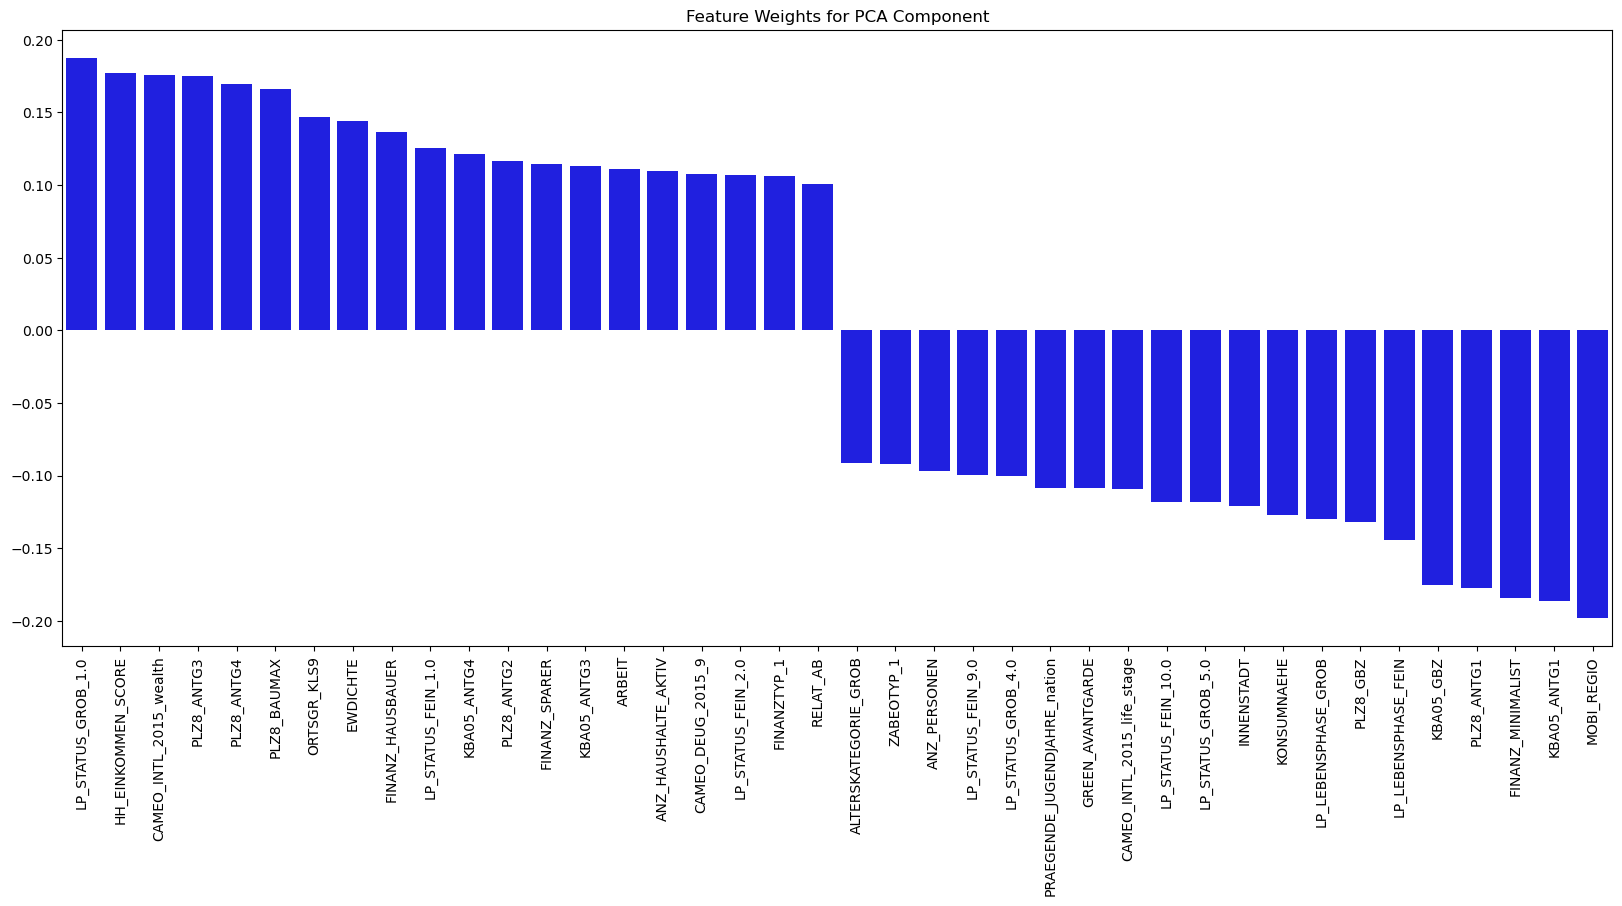

In [40]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
print('--First Component Feature Weights--')
component_0 = get_component_weights(pca, 0)
plot_weights_subset(component_0, 20)

--Second Component Feature Weights--


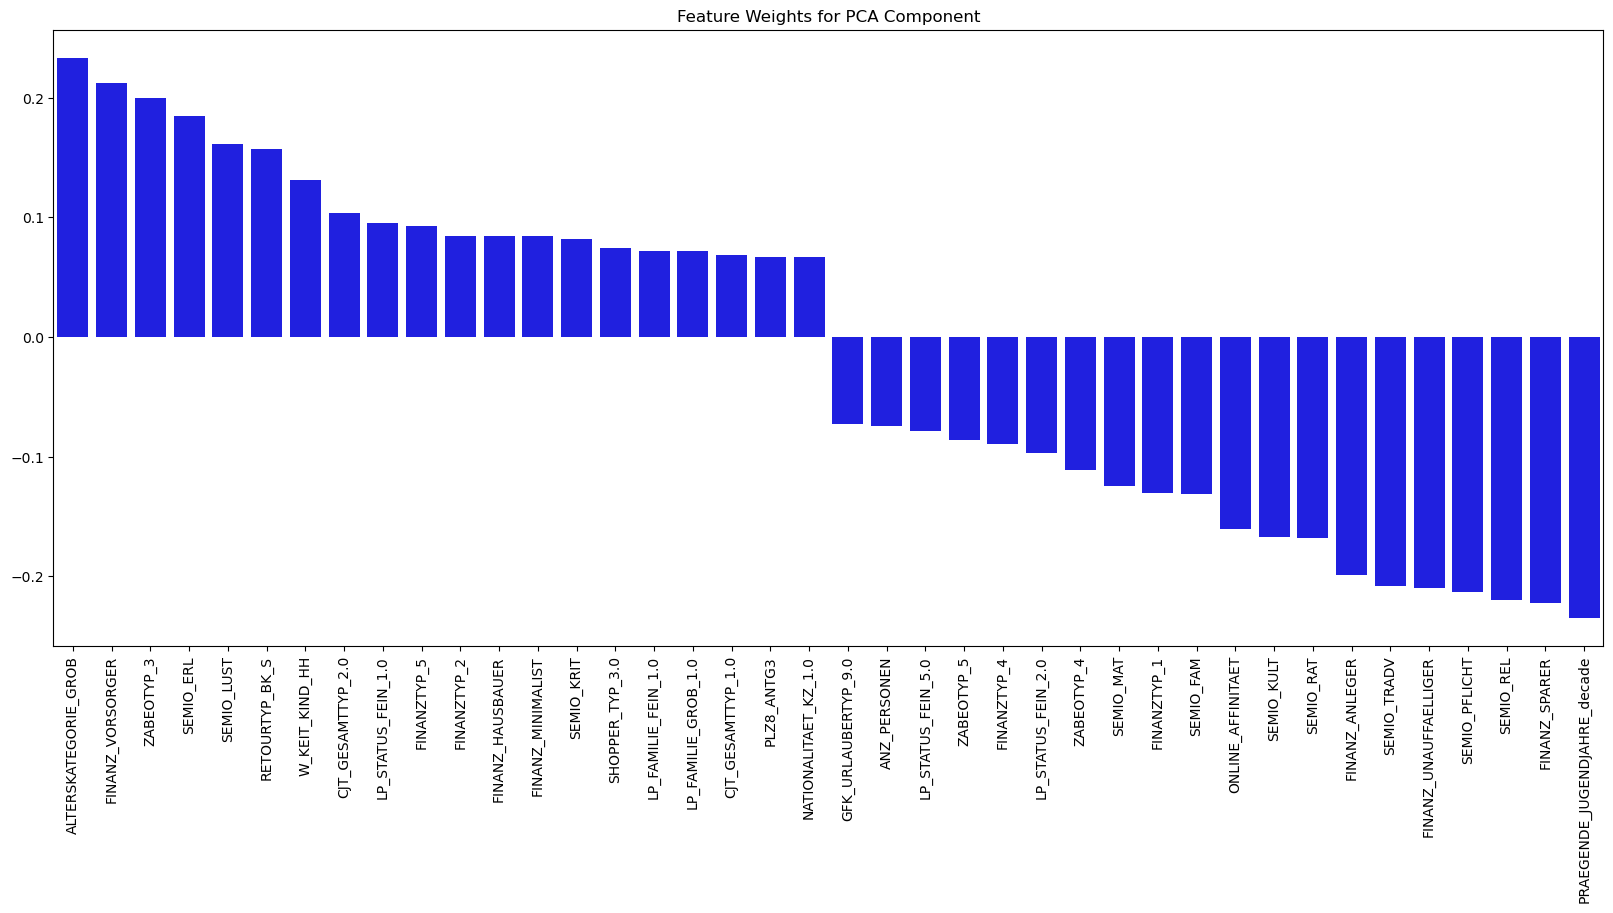

In [41]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print('--Second Component Feature Weights--')
component_1 = get_component_weights(pca, 1)
plot_weights_subset(component_1, 20)


--Third Component Feature Weights--


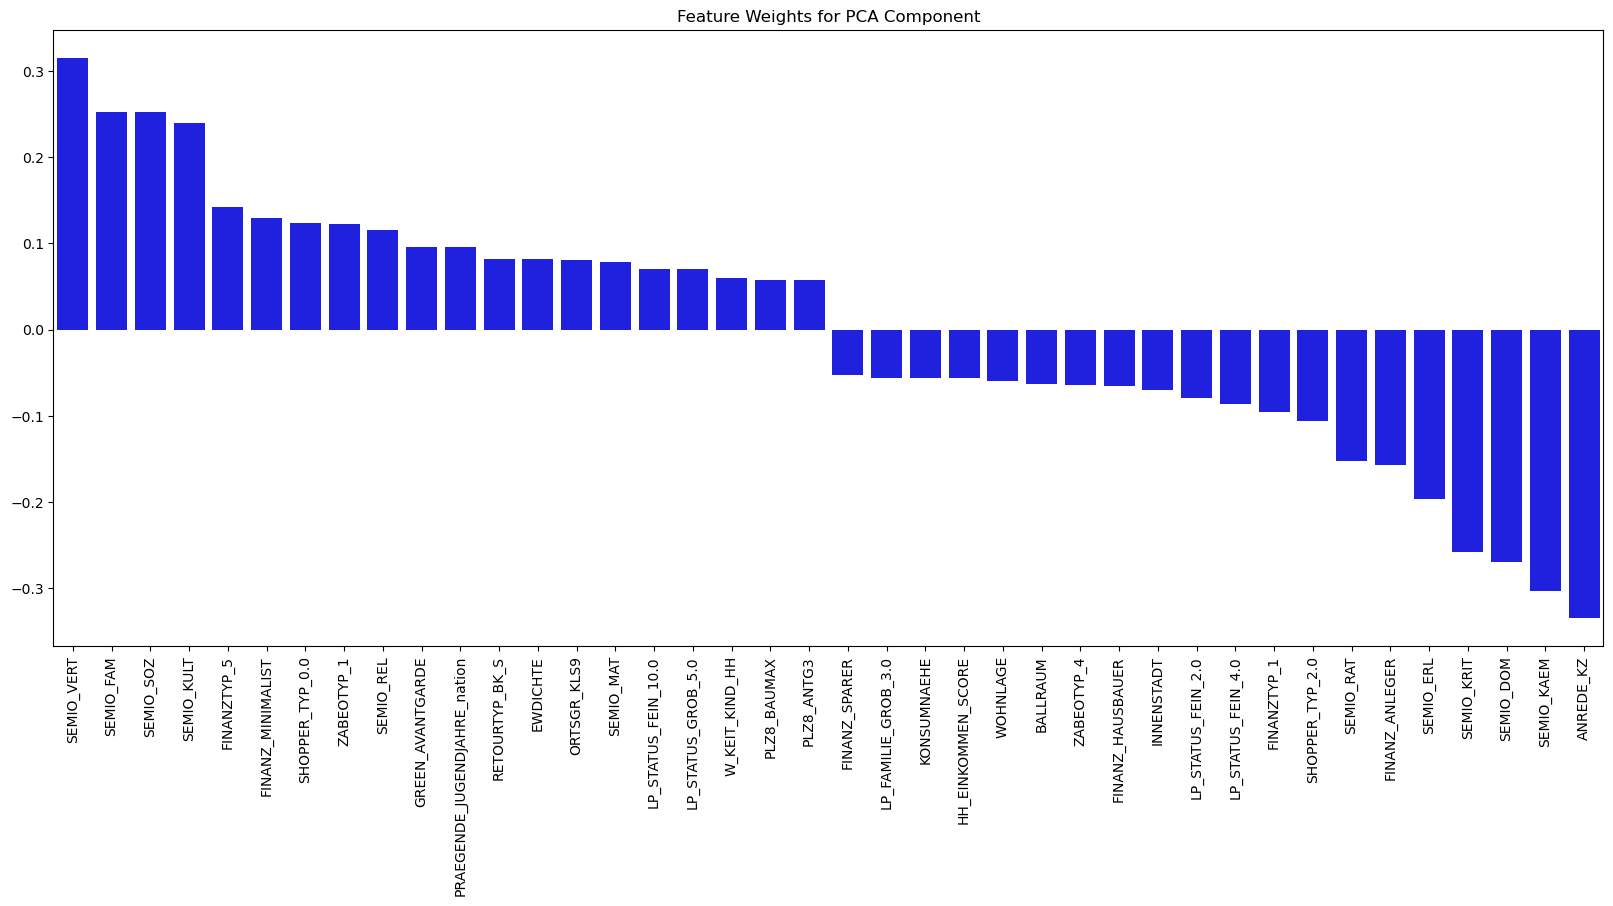

In [42]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print('--Third Component Feature Weights--')
component_2 = get_component_weights(pca, 2)
plot_weights_subset(component_2, 20)


### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

In the first component, the top 3 weights are LP_STATUS_GROB_1.0, HH_EINKOMMEN_SCORE, and CAMEO_INTL_2015_wealth and the bottom 3 weights are MOBI_REGIO, KBA05_ANTG1, and FINANZ_MINIMALIST.  These values suggest a latent feature associated with wealth and mobility. 
Low values of the top 3 are associated with high wealth and low values in the bottom 3 components are assocatied with very high movement, lower number of small families, and lower interest in finance.  So the positive and negative weights in for this feature make sense as it suggests that a wealthy person would have a smaller family and move less and also have a higher interest in finance.  And that makes sense.

The second component highest pos and negative value both deal with age.  So the second component could be thought of as an age component. The other features associated with this component are things like financial preparedness, money saving, religion, and engergy consumption typology, but I'm not sure what latent feature would involve these attributes, other than they may be correated somehow with age.

The third component looks to be associated with gender and overal disposition.  The largest negative values relate to gender, association with combatitve attitude or with dominant minded attitude.  So a larger value for these corresponds to being female and not associating with these more aggressive traits.  Those values would pair nicely with a small positive value for the positive component traits (being more dreamful, family oriented, or socially minded).

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [43]:
# Over a number of different cluster counts...
    # run k-means clustering on the data and..   
    # compute the average within-cluster distances.

n_clusters = np.arange(2, 31)
scores = [] # create a list to store the scores for the different cluster sizes

for clusters in n_clusters:
    kmeans = KMeans(n_clusters=clusters,
                    n_init='auto',
                    random_state=41)
    
    kmeans.fit(X_pca)
    scores.append((kmeans.score(X_pca)*-1) / len(X_pca))    

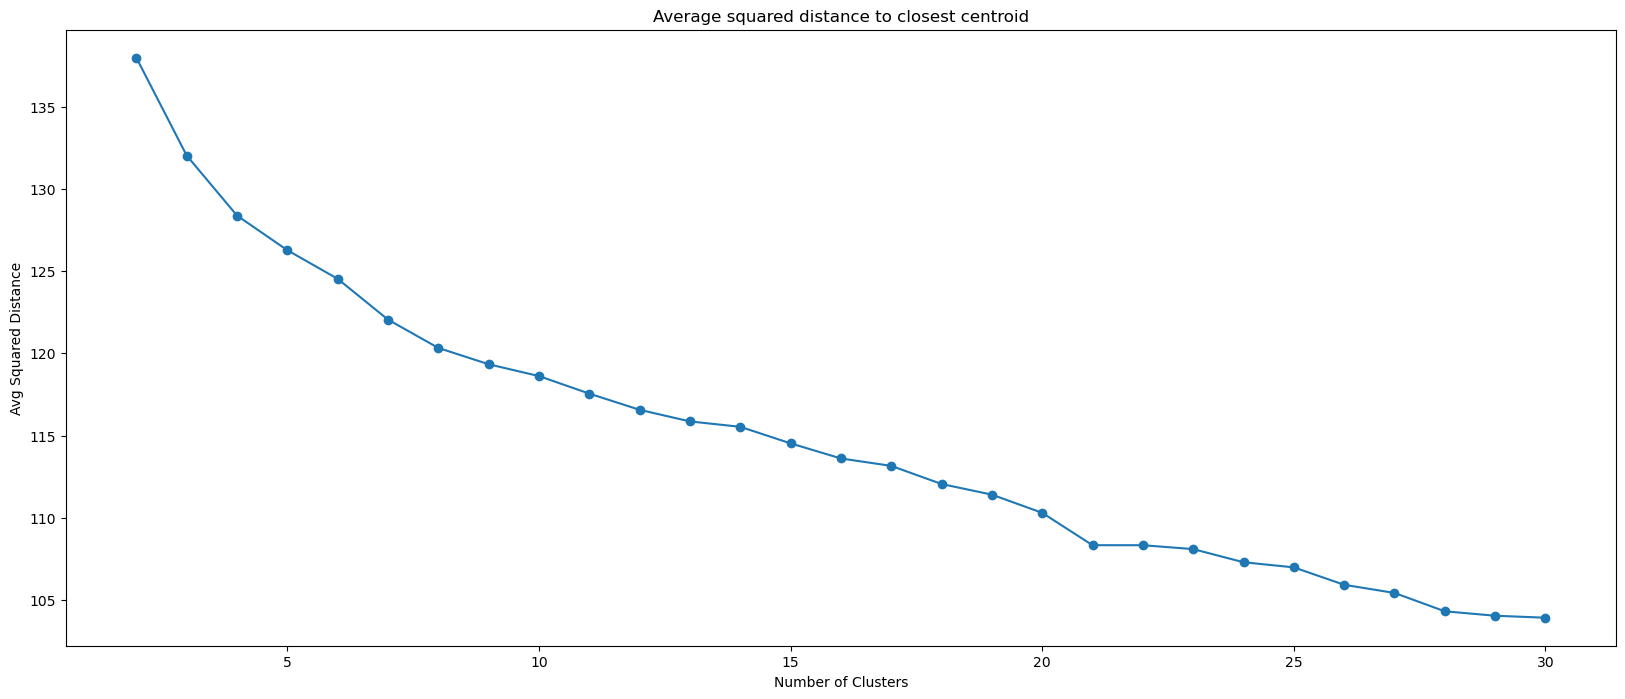

In [44]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.


fig, ax = plt.subplots(figsize=(20,8))
ax.plot(n_clusters, scores, marker='o');
ax.set_title("Average squared distance to closest centroid");
ax.set_xlabel("Number of Clusters");
ax.set_ylabel("Avg Squared Distance");

In [45]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters=13,
                n_init='auto',
                random_state=41)

kmeans_pred_generalpop = kmeans.fit_predict(X_pca)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

The scree plot above shows that up to 5 clusters the average squared distance drops by a relatively large amount.  There appears to be another slope transition change between 10 - 15 clusters.  Additional clusters do not reduce the average distance as much beyond this point.  Therefore 13 clusters are chosen as it is between 10 - 15 clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [46]:
# Load in the customer demographics data.
customers = pd.read_csv('./Udacity_CUSTOMERS_Subset.csv', sep=';')

In [47]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_clean = clean_data(customers)


In [48]:
# Apply feature scaling
customers_scaled = scaler.transform(customers_clean.dropna())

In [49]:
# Apply PCA
customer_PCA = pca.transform(customers_scaled)

In [50]:
# get predicted clusters based on PCA
kmeans_pred_customer = kmeans.predict(customer_PCA)

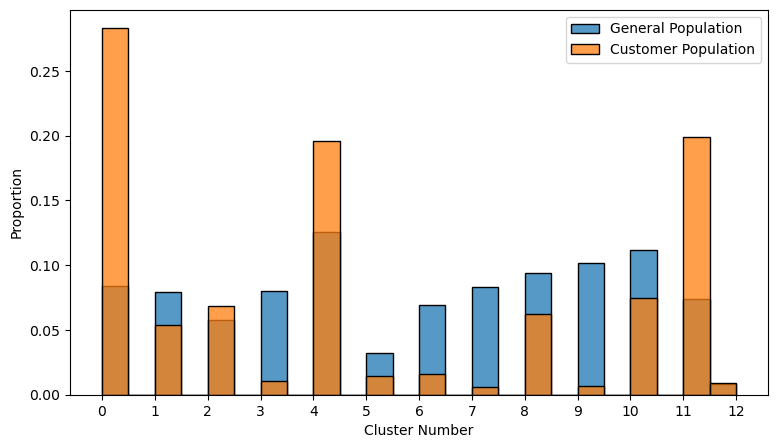

In [51]:
fig, ax = plt.subplots(figsize=(9,5));
sns.histplot(data=kmeans_pred_generalpop, stat='proportion', binwidth=0.5, label='General Population')
sns.histplot(data=kmeans_pred_customer, stat='proportion', binwidth=0.5, label = 'Customer Population')
plt.legend();
plt.xlabel('Cluster Number')
ax.set_xticks(range(0,13));


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [ ]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.



In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?



In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?



### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.